In [1]:
from scipy.constants import c,G,e,hbar,m_e,physical_constants
from urca_rate import mU_spec_net_rate
from scipy import interpolate
import copy
import numpy as np
import matplotlib.pyplot as plt
color_list=['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
dlnx_cs2=1e-10
unitMevfm=(hbar*c)/e*1e9
m_e_MeV=m_e*c**2/e/1e6
m_muon_MeV=physical_constants["muon mass"][0]*c**2/e/1e6

def HztoMev(before):
    return before*hbar*2*np.pi/(1e6*e)
    
def derivative(func, x, dx=1e-6):
    return (func(x + dx) - func(x - dx)) / (2 * dx)

def quality_control_none(eos_array):
    logic_faithful_range=np.logical_and(eos_array[0]<3,eos_array[2]<3000)
    logic_positive=(eos_array>0).min(axis=0)
    eos_array=eos_array[:,np.logical_and(logic_faithful_range,logic_positive)]
    logic_mono=np.concatenate((np.array([True]),(eos_array[:,1:]-eos_array[:,:-1]>0).min(axis=0)))
    eos_array=eos_array[:,logic_mono]
    eos_array_low=eos_array[:,eos_array[2]<200]
    success_causality=((eos_array_low[2,1:]-eos_array_low[2,:-1])<(eos_array_low[1,1:]-eos_array_low[1,:-1])).min()
    success_stiff_enough=eos_array_low[0,-1]<1.6
    success_baryondensity_range=eos_array[0,-1]>0.3
    success_pressure_range=eos_array[2,0]<3e-8 and eos_array[2,-1]>200
    success_eos_array=np.array([success_causality, success_stiff_enough, success_baryondensity_range, success_pressure_range])
    #success_eos=success_eos_array.min()
    #print(eos_array[2,0], eos_array[2,-1])
    #print(success_causality , success_stiff_enough , success_baryondensity_range , success_pressure_range)
    logic_mono=(eos_array[:,1:]<eos_array[:,:-1]).max(axis=0)
    index_max=np.where(logic_mono)
    p_max=eos_array[2,index_max][0]
    if(len(p_max)==0):
        p_max=eos_array[2,-1]
    else:
        p_max=p_max[0]
        eos_array=eos_array[:,:index_max[0][0]]
    return True,eos_array,p_max,success_eos_array

class EOS_interpolation(object):
    def __init__(self,baryon_density_s,eos_array,quality_control_f=quality_control_none,s_k=[0,2],eos_array_adiabatic=[],eos_array_Ylep=[]): #defalt s=0,k=3 equal quadratic 1d intepolation
        self.s,self.k=s_k
        if(len(eos_array)==2):
            n_array,energy_array=eos_array
            eosDensity_frombaryon = interpolate.UnivariateSpline(n_array,energy_array, k=self.k,s=self.s)
            pressure_array=derivative(eosDensity_frombaryon,n_array,dx=n_array*dlnx_cs2**0.5)*n_array-energy_array
            eos_array=np.array([n_array,energy_array,pressure_array])
        else:
            pass
        self.success_eos,self.eos_array,self.p_max,self.success_eos_array=quality_control_f(eos_array)
        n_array,energy_array,pressure_array=self.eos_array
        self.has_varyT=False
        if(self.success_eos):
            self.eosPressure_frombaryon = interpolate.UnivariateSpline(n_array,pressure_array, k=self.k,s=self.s)
            self.eosDensity  = interpolate.UnivariateSpline(pressure_array,energy_array, k=self.k,s=self.s)
            self.eosBaryonDensity = interpolate.UnivariateSpline(pressure_array,n_array, k=self.k,s=self.s)
            if(len(eos_array_adiabatic)==4):
                self.eos_array_adiabatic=eos_array_adiabatic
                self.eosCs2_adiabatic_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[3], k=max(self.k-1,1),s=self.s)
                self.has_cs2_adiabatic=True
                self.has_cs2_dynamic=False
                self.has_dChempo_dY=False
            elif(len(eos_array_adiabatic)==12):
                self.eos_array_adiabatic=eos_array_adiabatic
                self.eosMp_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[3], k=max(self.k-1,1),s=self.s)
                self.eosMn_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[4], k=max(self.k-1,1),s=self.s)
                self.eosChempo_lep_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[6]-self.eos_array_adiabatic[5], k=max(self.k-1,1),s=self.s)
                self.eosYp_int  = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[7], k=max(self.k-1,1),s=self.s)
                self.eoskFp_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[8], k=max(self.k-1,1),s=self.s)
                self.eoskFn_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[9], k=max(self.k-1,1),s=self.s)
                self.eosCs2_adiabatic_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[10]*self.eos_array_adiabatic[2]/(self.eos_array_adiabatic[1]+self.eos_array_adiabatic[2]), k=max(self.k-1,1),s=self.s)
                self.eosdChempo_dY_int    = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[11], k=max(self.k-1,1),s=self.s)
                self.has_cs2_adiabatic=True
                self.has_cs2_dynamic=True
                self.has_dChempo_dY=True
            else:
                self.has_cs2_adiabatic=False
                self.has_dChempo_dY=False
            if(len(eos_array_Ylep)==4):
                self.eos_array_Ylep=eos_array_Ylep
                self.eosYlep_int = interpolate.UnivariateSpline(self.eos_array_Ylep[2],self.eos_array_Ylep[3], k=max(self.k-1,1),s=self.s)
                self.eosYqak_int = lambda x:0
                self.has_Ylep=True
                self.has_Yqak=False
            elif(len(eos_array_Ylep)==5):
                self.eos_array_Ylep=eos_array_Ylep
                self.eosYlep_int = interpolate.UnivariateSpline(self.eos_array_Ylep[2],self.eos_array_Ylep[3], k=max(self.k-1,1),s=self.s)
                self.eosYqak_int = interpolate.UnivariateSpline(self.eos_array_Ylep[2],self.eos_array_Ylep[4], k=max(self.k-1,1),s=self.s)
                self.has_Ylep=True
                self.has_Yqak=True
            else:
                self.has_Ylep=False
                self.has_Yqak=False
            self.chempo_surface=(pressure_array[0]+energy_array[0])/n_array[0]
            self.baryon_density_s=baryon_density_s
            self.pressure_s=self.eosPressure_frombaryon(self.baryon_density_s)
            self.density_s=self.eosDensity(self.pressure_s)
            self.unit_mass=c**4/(G**3*self.density_s*1e51*e)**0.5
            self.unit_radius=c**2/(G*self.density_s*1e51*e)**0.5
            self.unit_N=self.unit_radius**3*self.baryon_density_s*1e45
        else:
            tmp=self.success_eos_array
            for item_name in [*self.__dict__]:  #this two lines is added on 8/15/2019
                del self.__dict__[item_name]    #to try free some memories.
            self.success_eos=False
            self.success_eos_array=tmp
            self.eosPressure_frombaryon,self.eosDensity,self.eosBaryonDensity = ['undefined']*3
    def __getstate__(self):
        state = self.__dict__.copy()
        for dict_intepolation in ['eosPressure_frombaryon','eosDensity','eosBaryonDensity']:
            del state[dict_intepolation]
        if(self.has_cs2_adiabatic):
            if(self.has_cs2_dynamic):
                for dict_intepolation in ['eosMp_int','eosMn_int','eosChempo_lep_int','eosYp_int','eoskFp_int','eoskFn_int','eosCs2_adiabatic_int','eosdChempo_dY_int']:
                    del state[dict_intepolation]
            else:
                del state['eosCs2_adiabatic_int']
        if(self.has_varyT):
            del state['T_MeV_from_pressure_int']
        if(self.has_Ylep):
            del state['eosYlep_int']
        if(self.has_Yqak):
            del state['eosYqak_int']
        return state
    def __setstate__(self, state):
        self.__dict__.update(state)
        if(self.success_eos):
            n_array,energy_array,pressure_array=self.eos_array
            self.eosPressure_frombaryon = interpolate.UnivariateSpline(n_array,pressure_array, k=self.k,s=self.s)
            self.eosDensity  = interpolate.UnivariateSpline(pressure_array,energy_array, k=self.k,s=self.s)
            self.eosBaryonDensity = interpolate.UnivariateSpline(pressure_array,n_array, k=self.k,s=self.s)
            if(self.has_cs2_adiabatic):
                if(self.has_cs2_dynamic):
                    self.eosMp_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[3], k=max(self.k-1,1),s=self.s)
                    self.eosMn_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[4], k=max(self.k-1,1),s=self.s)
                    self.eosChempo_lep_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[6]-self.eos_array_adiabatic[5], k=max(self.k-1,1),s=self.s)
                    self.eosYp_int  = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[7], k=max(self.k-1,1),s=self.s)
                    self.eoskFp_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[8], k=max(self.k-1,1),s=self.s)
                    self.eoskFn_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[9], k=max(self.k-1,1),s=self.s)
                    self.eosCs2_adiabatic_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[10]*self.eos_array_adiabatic[2]/(self.eos_array_adiabatic[1]+self.eos_array_adiabatic[2]), k=max(self.k-1,1),s=self.s)
                    self.eosdChempo_dY_int    = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[11], k=max(self.k-1,1),s=self.s)
                else:
                    self.eosCs2_adiabatic_int = interpolate.UnivariateSpline(self.eos_array_adiabatic[2],self.eos_array_adiabatic[3], k=max(self.k-1,1),s=self.s)
            if(self.has_varyT):
                self.T_MeV_from_pressure_int=interpolate.UnivariateSpline(self.data_pT[0],self.data_pT[1], k=max(self.k-1,1),s=self.s)
            if(self.has_Ylep):
                self.eosYlep_int = interpolate.UnivariateSpline(self.eos_array_Ylep[2],self.eos_array_Ylep[3], k=max(self.k-1,1),s=self.s)
            if(self.has_Yqak):
                self.eosYqak_int = interpolate.UnivariateSpline(self.eos_array_Ylep[2],self.eos_array_Ylep[4], k=max(self.k-1,1),s=self.s)
        else:
            self.eosPressure_frombaryon,self.eosDensity,self.eosBaryonDensity = ['undefined']*3
    def eosChempo(self,pressure):
        return (pressure+self.eosDensity(pressure))/self.eosBaryonDensity(pressure)
    def eosCs2(self,pressure):
        return 1.0/derivative(self.eosDensity,pressure,dx=self.eosDensity(pressure)*dlnx_cs2)
    def eosCs2_adiabatic(self,pressure):
        return np.where(np.logical_and(self.eos_array_adiabatic[2].min()<=pressure,pressure<=self.eos_array_adiabatic[2].max()),self.eosCs2_adiabatic_int(pressure),self.eosCs2(pressure))
    def eosCs2_dynamic(self,pressure,omega_MeV,T_MeV):
        return self.eosCs2(pressure)+(self.eosCs2_adiabatic(pressure)-self.eosCs2(pressure))/(1+self.eosdChempo_dY_int(pressure)*self.eosUrca_lambda(pressure,T_MeV)/(omega_MeV*self.eosBaryonDensity(pressure))*1j)
    def eosCs2_dynamic_varyT(self,pressure,omega_MeV,T_MeV_dummy):
        self.has_varyT=True
        T_MeV=self.T_MeV_from_pressure_int(pressure)
        return self.eosCs2(pressure)+(self.eosCs2_adiabatic(pressure)-self.eosCs2(pressure))/(1+self.eosdChempo_dY_int(pressure)*self.eosUrca_lambda(pressure,T_MeV)/(omega_MeV*self.eosBaryonDensity(pressure))*1j)
    def set_T_MeV_from_pressure(self,data_nT):
        self.has_varyT=True
        self.data_pT=np.array([self.eosPressure_frombaryon(data_nT[0]),data_nT[1]])
        self.T_MeV_from_pressure_int=interpolate.UnivariateSpline(self.data_pT[0],self.data_pT[1], k=max(self.k-1,1),s=self.s)
    def eosUrca_lambda(self,pressure,T_MeV):#in unit fm-3
        mp=self.eosMp_int(pressure)
        mn=self.eosMn_int(pressure)
        kfp=self.eoskFp_int(pressure)
        kfn=self.eoskFn_int(pressure)
        kfe,kfmu=self.eoskF_lep(pressure)
        return mU_spec_net_rate(mp,mn,kfp,kfn,kfe,kfmu,T_MeV)/unitMevfm**3
    def eoskF_lep(self,pressure,m_e=m_e_MeV, m_muon=m_muon_MeV):
        chempo_lep=self.eosChempo_lep_int(pressure)
        k_F_e=np.where(chempo_lep>m_e,chempo_lep**2-m_e**2,0)**0.5
        k_F_muon=np.where(chempo_lep>m_muon,chempo_lep**2-m_muon**2,0)**0.5
        return k_F_e,k_F_muon
        

In [2]:
s_k=[0,2]
eos_name_list=['QMC-RMF3', 'IUFSU', 'IOPB-I']
omega_g_mode_max_list=[]
omega_g_mode_one_list=[]
omega_g_mode_one_list_second=[]
eos_list=[]
eos_eq_list=[]
for eos_name in eos_name_list:
    eos_array=np.loadtxt('./EOS_table/'+eos_name+'_withcrust.txt').transpose()
    
    eos=EOS_interpolation(0.16,eos_array[:3],eos_array_adiabatic=eos_array[:,eos_array[-1]!=0],s_k=s_k)
    eos_list.append(eos)
    eos_eq_list.append(EOS_interpolation(0.16,eos_array[:3]))

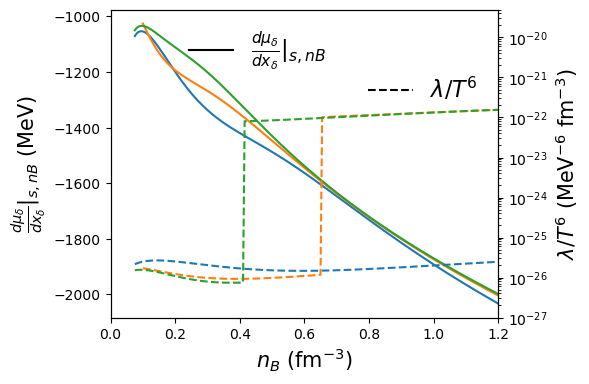

In [3]:

fig,ax=plt.subplots(1,1,figsize=(5,4),sharex=False,sharey=False)
ax_twinx=ax.twinx()
for i,eos in enumerate(eos_list):
    p_plot=eos.eos_array_adiabatic[2]
    ax.plot(eos.eosBaryonDensity(p_plot),eos.eosdChempo_dY_int(p_plot),color=color_list[i])
    ax_twinx.plot(eos.eosBaryonDensity(p_plot),eos.eosUrca_lambda(p_plot,1),'--',color=color_list[i])

ax.set_ylabel('$\\frac{d\mu_\delta}{dx_\delta}|_{s,nB}$ (MeV)',fontsize=15)
ax.set_xlabel('$n_B$ (fm$^{-3}$)',fontsize=15)
ax.set_xlim(0,1.2)

ax_twinx.set_ylabel('$\lambda/T^6$ (MeV$^{-6}$ fm$^{-3}$)',fontsize=15)
#ax_twinx.set_ylabel('$\lambda/T^4$ (MeV$^{-4}$ fm$^{-2}$)',fontsize=15)
ax_twinx.set_ylim(1e-27,5e-20)
ax_twinx.set_yscale('log')
   
ax.plot([],[],'k',label='$\\frac{d\mu_\delta}{dx_\delta}|_{s,nB}$')
ax_twinx.plot([],[],'--k',label='$\lambda/T^6$')
#ax_twinx.plot([],[],'--k',label='$\lambda/T^$')
ax.legend(frameon=False,fontsize=16,loc='upper left',bbox_to_anchor=(0.15, 1))
ax_twinx.legend(frameon=False,fontsize=16,loc='upper right',bbox_to_anchor=(1, 0.85))

plt.savefig('./figures/dmudx.pdf',bbox_inches = 'tight',format='pdf')

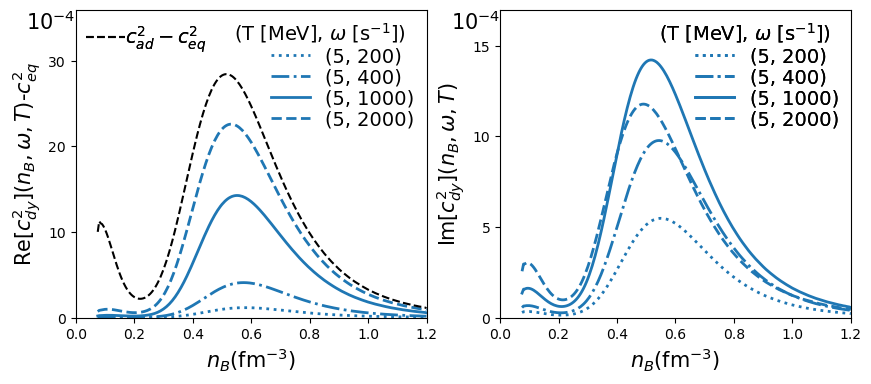

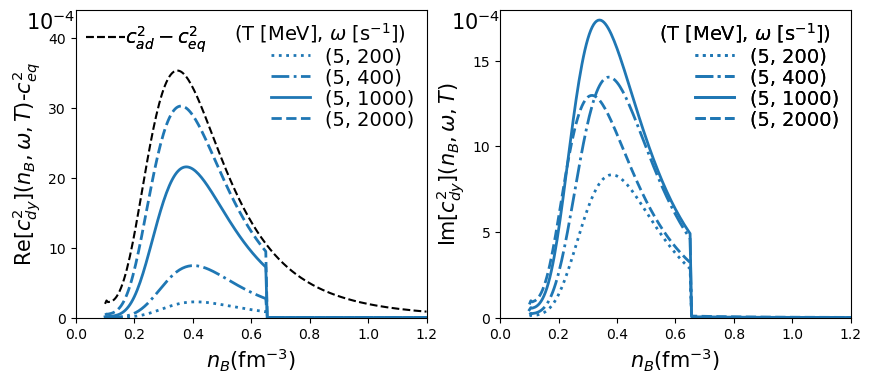

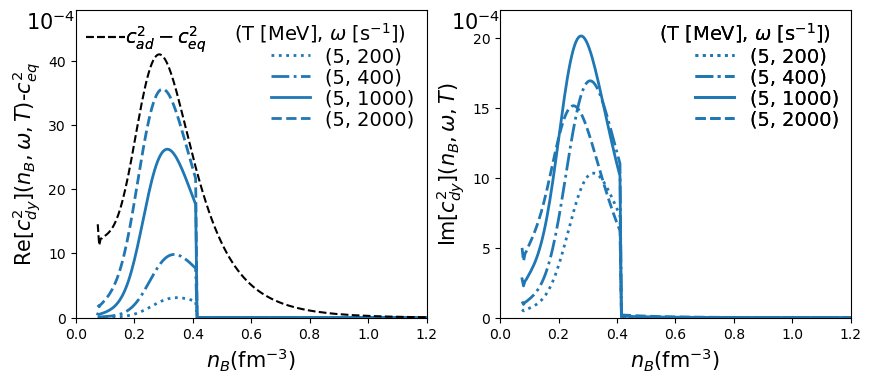

In [4]:
y_max_list=[[36,17],[44,18],[48,22]]
#title='(T [MeV], $\\frac{\omega}{2\pi}$ [Hz])        '
title='(T [MeV], $\omega$ [s$^{-1}$])        '
#omega_Hz_list=[20,50,100,200]
omega_Hz_list=np.array([200,400,1000,2000])/(2*np.pi)

for eos,y_max,name in zip(eos_list,y_max_list,eos_name_list):
    p_plot=eos.eos_array_adiabatic[2]
    fig, axes = plt.subplots(1, 2,figsize=(10,4),sharex=True,sharey=False)
    plt.subplots_adjust(wspace=.21,hspace=0)

    T_MeV_list=[5]

    ls_list=[':','-.','-','--']
    cs2_dynamic_imag_max=[]
    lines1=[]
    lines2=[]
    for T_MeV,color in zip(T_MeV_list,color_list):
        for omega_Hz,ls in zip(omega_Hz_list,ls_list):
            omega_s=omega_Hz*2*np.pi
            omega_MeV=HztoMev(omega_Hz)
            cs2_dynamic=eos.eosCs2_dynamic(p_plot,omega_MeV,T_MeV)
            cs2_dynamic_real=cs2_dynamic.real
            cs2_dynamic_imag=cs2_dynamic.imag
            lines1+=axes[0].plot(eos.eosBaryonDensity(p_plot),1e4*(cs2_dynamic_real-eos.eosCs2(p_plot)),color=color,lw=2,ls=ls,label='(%d, %d)'%(T_MeV,omega_s))
            cs2_dynamic_imag_max.append(cs2_dynamic_imag[20:].max())
            lines2+=axes[1].plot(eos.eosBaryonDensity(p_plot),1e4*cs2_dynamic_imag,color=color,lw=2,ls=ls,label='(%d, %d)'%(T_MeV,omega_s))
    cs2_dynamic_imag_max=np.array(cs2_dynamic_imag_max).reshape((len(T_MeV_list),len(omega_Hz_list)))


    axes[0].set_xlabel('$n_B$(fm$^{-3}$)',fontsize=15)
    axes[1].set_xlabel('$n_B$(fm$^{-3}$)',fontsize=15)
    axes[0].set_ylabel('Re[$c_{dy}^2$]($n_B,\omega,T$)-$c_{eq}^2$',fontsize=15)
    axes[1].set_ylabel('Im[$c_{dy}^2$]($n_B,\omega,T$)',fontsize=15)

    axes[0].set_xlim(0,1.2)
    axes[0].set_ylim(0,y_max[0])
    axes[1].set_ylim(0,y_max[1])
    axes[0].set_yticks(range(0,y_max[0],10))
    axes[1].set_yticks(range(0,y_max[1],5))
    axes[0].text(0,y_max[0],'10$^{-4}$',fontsize=15,ha='right',va='top')
    axes[1].text(0,y_max[1],'10$^{-4}$',fontsize=15,ha='right',va='top')
    
    first_legend = axes[0].legend(ncols=1,columnspacing=0,labelspacing=0.1,handles=lines1,fontsize=14,frameon=False, loc='upper right',title=title,title_fontsize=14,bbox_to_anchor=(1.12, 1.02))
    axes[0].add_artist(first_legend)

    first_legend = axes[1].legend(ncols=1,columnspacing=0,labelspacing=0.1,handles=lines2,fontsize=14,frameon=False, loc='upper right',title=title,title_fontsize=14,bbox_to_anchor=(1.12, 1.02))
    axes[1].add_artist(first_legend)


    lines=axes[0].plot(eos.eosBaryonDensity(p_plot),1e4*(eos.eosCs2_adiabatic(p_plot)-eos.eosCs2(p_plot)),'--k',label='$c_{ad}^2-c_{eq}^2$')
    second_legend = axes[0].legend(ncols=1,columnspacing=0,labelspacing=0.1,handletextpad=-0.02,handles=lines,fontsize=14,frameon=False,title_fontsize=11, loc='upper left',bbox_to_anchor=(-0.02, 1.01))
    axes[0].add_artist(second_legend)

    plt.savefig('./figures/cs2_dynamic_vary_omega_%s.pdf'%name,bbox_inches = 'tight',format='pdf')


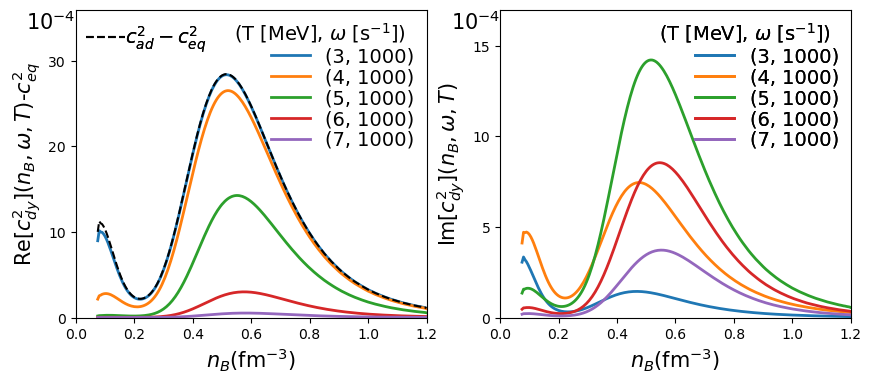

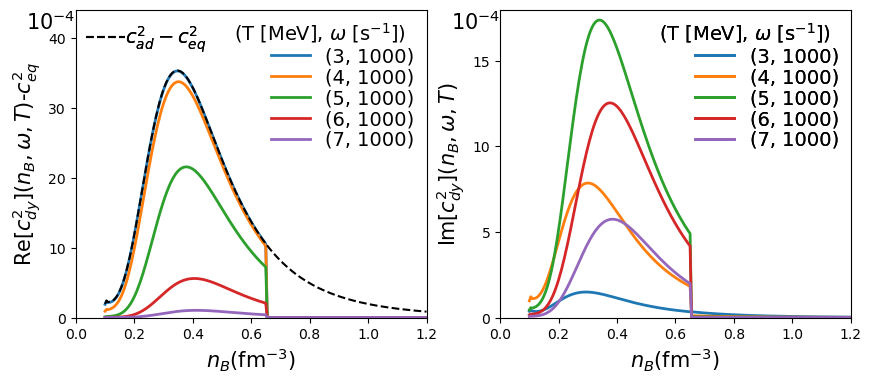

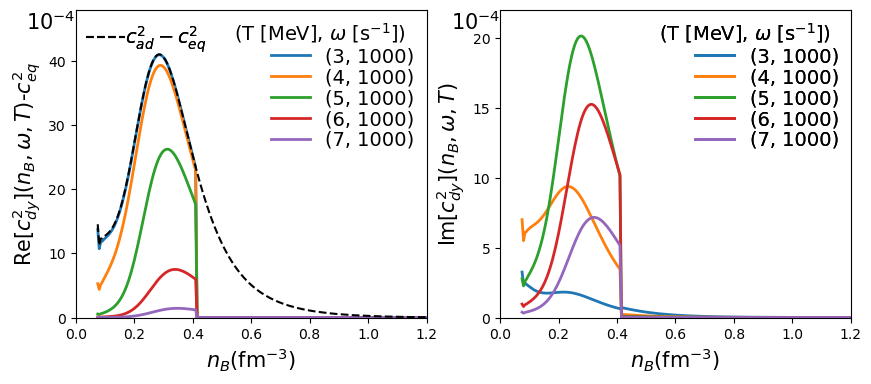

In [5]:

y_max_list=[[36,17],[44,18],[48,22]]
for eos,y_max,name in zip(eos_list,y_max_list,eos_name_list):
    p_plot=eos.eos_array_adiabatic[2]
    fig, axes = plt.subplots(1, 2,figsize=(10,4),sharex=True,sharey=False)
    plt.subplots_adjust(wspace=.21,hspace=0)

    T_MeV_list=[3,4,5,6,7]
    #omega_Hz_list=[100]
    omega_Hz_list=[1000/(2*np.pi)]
    ls_list=['-']
    cs2_dynamic_imag_max=[]
    lines1=[]
    lines2=[]
    for T_MeV,color in zip(T_MeV_list,color_list):
        for omega_Hz,ls in zip(omega_Hz_list,ls_list):
            omega_s=omega_Hz*2*np.pi
            omega_MeV=HztoMev(omega_Hz)
            cs2_dynamic=eos.eosCs2_dynamic(p_plot,omega_MeV,T_MeV)
            cs2_dynamic_real=cs2_dynamic.real
            cs2_dynamic_imag=cs2_dynamic.imag
            lines1+=axes[0].plot(eos.eosBaryonDensity(p_plot),1e4*(cs2_dynamic_real-eos.eosCs2(p_plot)),color=color,lw=2,ls=ls,label='(%d, %d)'%(T_MeV,omega_s))
            cs2_dynamic_imag_max.append(cs2_dynamic_imag[20:].max())
            lines2+=axes[1].plot(eos.eosBaryonDensity(p_plot),1e4*cs2_dynamic_imag,color=color,lw=2,ls=ls,label='(%d, %d)'%(T_MeV,omega_s))
    cs2_dynamic_imag_max=np.array(cs2_dynamic_imag_max).reshape((len(T_MeV_list),len(omega_Hz_list)))


    axes[0].set_xlabel('$n_B$(fm$^{-3}$)',fontsize=15)
    axes[1].set_xlabel('$n_B$(fm$^{-3}$)',fontsize=15)
    axes[0].set_ylabel('Re[$c_{dy}^2$]($n_B,\omega,T$)-$c_{eq}^2$',fontsize=15)
    axes[1].set_ylabel('Im[$c_{dy}^2$]($n_B,\omega,T$)',fontsize=15)

    axes[0].set_xlim(0,1.2)
    axes[0].set_ylim(0,y_max[0])
    axes[1].set_ylim(0,y_max[1])
    axes[0].set_yticks(range(0,y_max[0],10))
    axes[1].set_yticks(range(0,y_max[1],5))
    axes[0].text(0,y_max[0],'10$^{-4}$',fontsize=15,ha='right',va='top')
    axes[1].text(0,y_max[1],'10$^{-4}$',fontsize=15,ha='right',va='top')

    first_legend = axes[0].legend(ncols=1,columnspacing=0,labelspacing=0.1,handles=lines1,fontsize=14,frameon=False, loc='upper right',title=title,title_fontsize=14,bbox_to_anchor=(1.12, 1.02))
    axes[0].add_artist(first_legend)

    first_legend = axes[1].legend(ncols=1,columnspacing=0,labelspacing=0.1,handles=lines2,fontsize=14,frameon=False, loc='upper right',title=title,title_fontsize=14,bbox_to_anchor=(1.12, 1.02))
    axes[1].add_artist(first_legend)


    lines=axes[0].plot(eos.eosBaryonDensity(p_plot),1e4*(eos.eosCs2_adiabatic(p_plot)-eos.eosCs2(p_plot)),'--k',label='$c_{ad}^2-c_{eq}^2$')
    second_legend = axes[0].legend(ncols=1,columnspacing=0,labelspacing=0.1,handletextpad=-0.02,handles=lines,fontsize=14,frameon=False,title_fontsize=11, loc='upper left',bbox_to_anchor=(-0.02, 1.01))
    axes[0].add_artist(second_legend)

    plt.savefig('./figures/cs2_dynamic_vary_T_%s.pdf'%name,bbox_inches = 'tight',format='pdf')